# Performative Prediciton: A Case Study in Strategic Classification

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scripts.optimization import evaluate_loss, logistic_regression

import whynot as wn
import whynot.gym as gym

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Set up Repeated Classification Environment

We perform our experiments on the *Give me a credit* dataset available at https://www.kaggle.com/c/GiveMeSomeCredit. The dataset contains features of individuals and an indicator variable on whether they defaulted on a loan or not.

In [2]:
# Make the Credit environment and set random seed.
np.random.seed(0)
env = gym.make('Credit-v0')
env.seed(1)

[1]

## 2) Simulation

### Initial ERM Classifier

We train a logistic regression classifier on the given set of features and labels. 
This corresponds to the classical supervised learning procedure.

In [3]:
# fit logistic regression model we treat as the truth
base_features, base_labels = env.initial_state.values()
num_agents, num_features = base_features.shape

lam = 1.0 / num_agents
theta_true, loss_list, smoothness = logistic_regression(base_features, base_labels, lam, 'Exact')

print('Accuracy: ', ((base_features.dot(theta_true) > 0)  == base_labels).mean())
print('Loss: ', loss_list[-1])
print('Condition Number: ', lam / (smoothness + lam))
print('Norm: ', np.linalg.norm(theta_true))

Accuracy:  0.7208149479762488
Loss:  0.6100457881235787
Condition Number:  1.1674064432758535e-05
Norm:  2.449254451036605


### Repeated ERM

We simulate the effect of performativity. Therefore we perform `num_iters` rounds. In each round the following three steps are performed: i) we train an ERM classifier on the current set of features, ii) the classifier is deployed and iii) the individuals react strategically to the deployed calssifier, inducing a new set of fetaures for the next round

a) configure experiment

In [4]:
# problems parameters
num_iters    = 25
eps_list = [1, 80, 150, 1000]
num_eps  = len(eps_list)

# define which method to run: 'Exact' or 'RGD'
method = 'Exact'  

b) setup summary statistics

In [5]:
theta_list         = [[np.copy(theta_true)] for _ in range(num_eps)]
theta_gaps         = [[] for _ in range(num_eps)]
ll_list            = [[] for _ in range(num_eps)]
acc_list_start     = [[] for _ in range(num_eps)]
acc_list_end       = [[] for _ in range(num_eps)]
lp_list_start      = [[] for _ in range(num_eps)]
lp_list_end        = [[] for _ in range(num_eps)]

c) simulate experiment

In [6]:
for c, eps in enumerate(eps_list):
    
    # initial theta
    theta = np.copy(theta_true)

    print('Running epsilon =  {}\n'.format(eps))
    
    env.config.epsilon = eps
    env.config.l2_penalty = lam
    env.reset()
    
    for t in range(num_iters):
 
       # print(env.state.features[:5])
        (X_strat, Y), _, _, _ = env.step(theta)
        
        # evaluate initial loss on the current distribution
        # performative loss value of previous theta
        loss_start = evaluate_loss(X_strat, Y, theta, lam)
        acc = ((X_strat.dot(theta) > 0) == Y).mean()
        
        acc_list_start[c].append(acc)
        lp_list_start[c].append(loss_start)
        
        # learn on induced distribution
        theta_init = np.copy(theta)
        
        theta_new, ll, _ = logistic_regression(X_strat, Y, lam, method, tol=1e-7,
                                               theta_init=theta_init)
    
        # keep track of statistics
        ll_list[c].append(ll)
        theta_list[c].append(np.copy(theta_new))

        # evaluate final loss on the current distribution
        loss_end = evaluate_loss(X_strat, Y, theta_new, lam)
        acc = ((X_strat.dot(theta_new) > 0) == Y).mean()
        
        lp_list_end[c].append(loss_end)        
        acc_list_end[c].append(acc)
        
        theta = np.copy(theta_new)
        
        #print(f"Iteration {t}: {loss_start:.3f}, {loss_end:.3f}")

Running epsilon =  1

Running epsilon =  80

Running epsilon =  150

Running epsilon =  1000



## 3) Visualization of Results

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'Times New Roman'

%matplotlib inline

 ### Perfromative Risk
 
 We visualize the perfromative risk during the repeated risk minimization procedure. We illustrate the risk at the beginning and at the end of each round, correcting the two values with a blue line and indicate the distribution shift with a dashed green line.

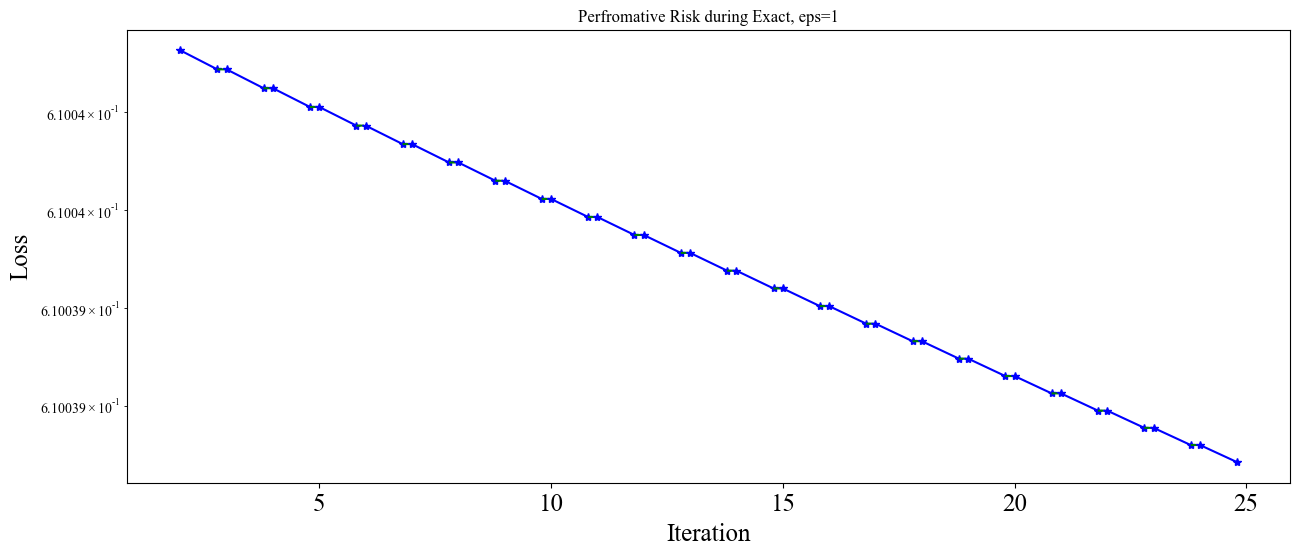

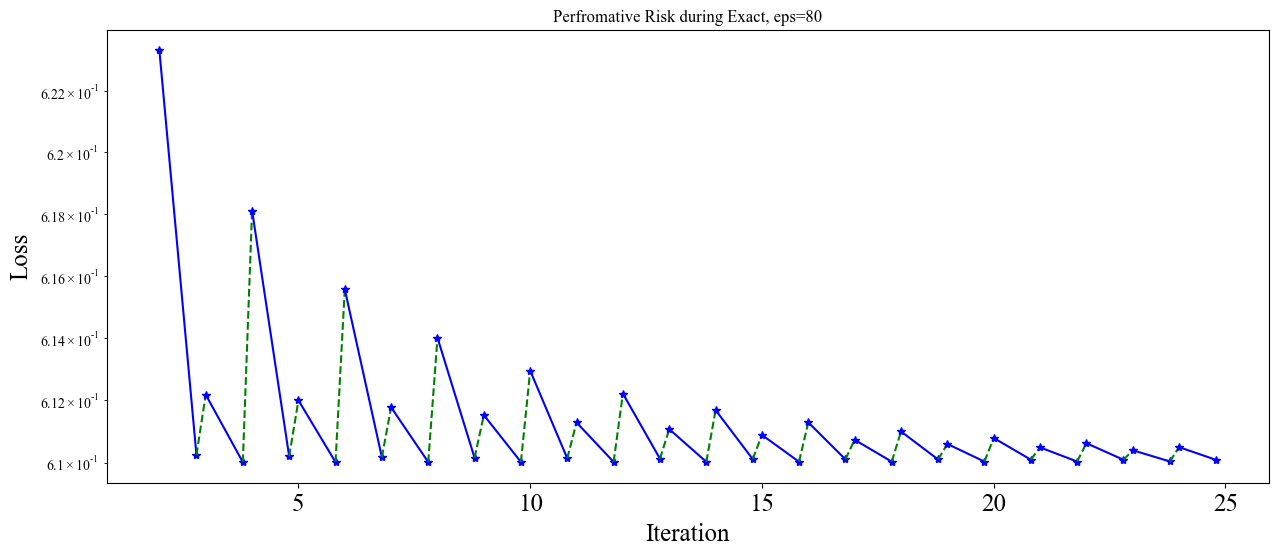

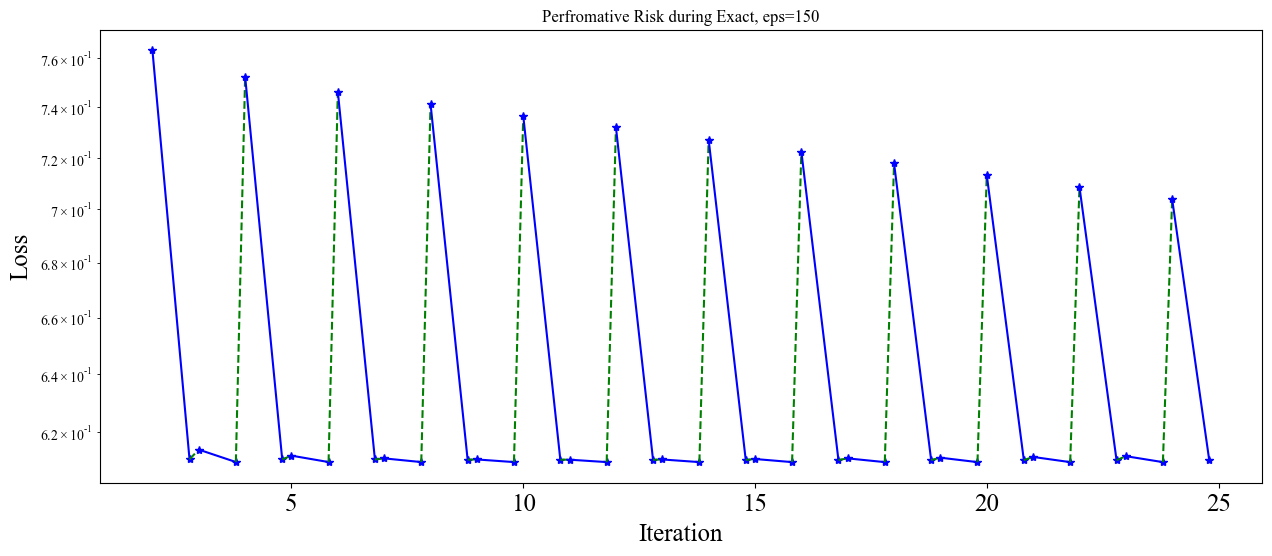

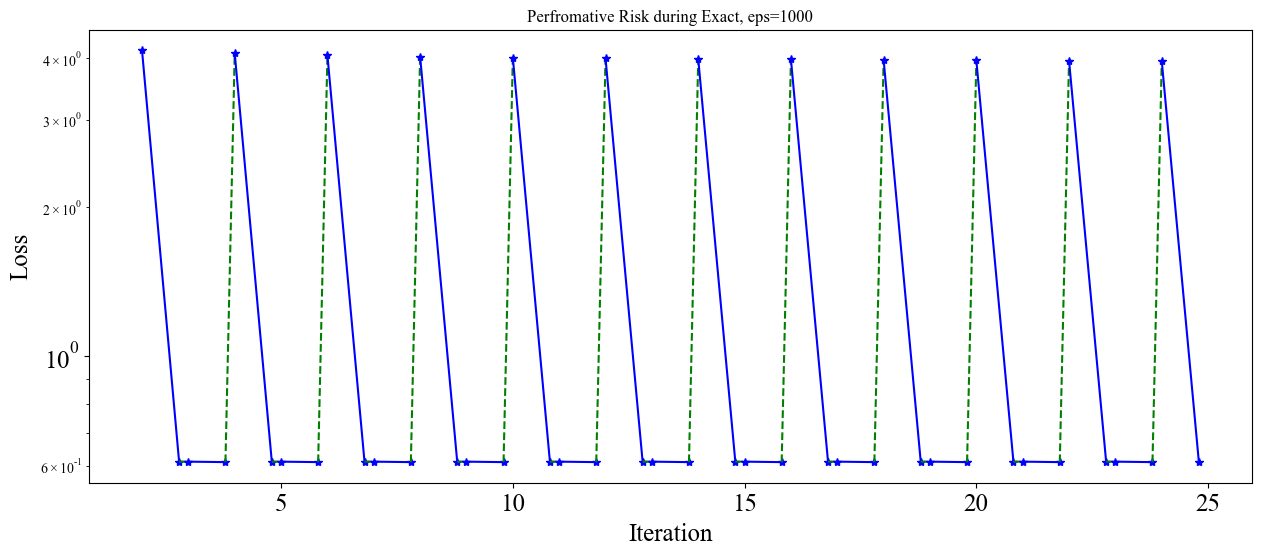

In [9]:
# visualize loss trajectory

for c in range(num_eps):
    plt.figure(figsize=(15,6))
    offset = 0.8
    plt.title('Perfromative Risk during {}, eps={}'.format(method,eps_list[c]))
    for i in range(2,num_iters):
        plt.plot([i,i+offset],[lp_list_start[c][i],lp_list_end[c][i]],'b*-')
        if i<num_iters-1:
            plt.plot([i+offset, i+1],[lp_list_end[c][i],lp_list_start[c][i+1]],'g--')

    plt.xlabel('Iteration',fontsize = 18)
    plt.ylabel('Loss',fontsize = 18) 
    plt.tick_params(labelsize=18)
    plt.yscale('log')